Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from glob import glob

In [3]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("C:/Users/abhis/Documents/Upgrad/Neural Network/CNN/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("C:/Users/abhis/Documents/Upgrad/Neural Network/CNN/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


#### Creating Original_df dataframe from training folders, subfolders and child directories

In [6]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename((os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
dataframe_dict = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])
display(original_df)

,Path,Label
0,C:\Users\abhis\Documents\Upgrad\Neural Network...,actinic keratosis
1,C:\Users\abhis\Documents\Upgrad\Neural Network...,actinic keratosis
2,C:\Users\abhis\Documents\Upgrad\Neural Network...,actinic keratosis
3,C:\Users\abhis\Documents\Upgrad\Neural Network...,actinic keratosis
4,C:\Users\abhis\Documents\Upgrad\Neural Network...,actinic keratosis
...,...,...
2234,C:\Users\abhis\Documents\Upgrad\Neural Network...,vascular lesion
2235,C:\Users\abhis\Documents\Upgrad\Neural Network...,vascular lesion
2236,C:\Users\abhis\Documents\Upgrad\Neural Network...,vascular lesion
2237,C:\Users\abhis\Documents\Upgrad\Neural Network...,vascular lesion


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [8]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

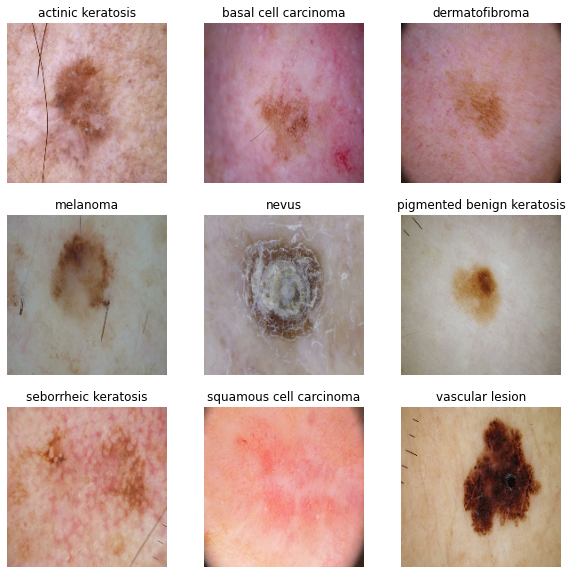

In [86]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[i])
    plt.axis("off")

In [12]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [14]:
### Your code goes here
num_classes = 9

model = Sequential([layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(), 
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes,activation = 'softmax')
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [15]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [16]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

### Train the model

In [17]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 10s 57ms/step - loss: 2.0304 - accuracy: 0.2673 - val_loss: 1.7188 - val_accuracy: 0.3736
Epoch 2/20
56/56 [==============================] - 2s 34ms/step - loss: 1.6763 - accuracy: 0.3945 - val_loss: 1.4945 - val_accuracy: 0.4720
Epoch 3/20
56/56 [==============================] - 2s 35ms/step - loss: 1.4776 - accuracy: 0.4972 - val_loss: 1.4264 - val_accuracy: 0.5369
Epoch 4/20
56/56 [==============================] - 2s 34ms/step - loss: 1.3360 - accuracy: 0.5301 - val_loss: 1.3696 - val_accuracy: 0.5414
Epoch 5/20
56/56 [==============================] - 2s 34ms/step - loss: 1.2217 - accuracy: 0.5664 - val_loss: 1.4111 - val_accuracy: 0.5324
Epoch 6/20
56/56 [==============================] - 2s 33ms/step - loss: 1.1706 - accuracy: 0.5837 - val_loss: 1.3249 - val_accuracy: 0.5615
Epoch 7/20
56/56 [==============================] - 2s 33ms/step - loss: 1.0674 - accuracy: 0.6155 - val_loss: 1.3772 - val_accuracy: 0.5347
Epoch 8/20
5

### Visualizing training results

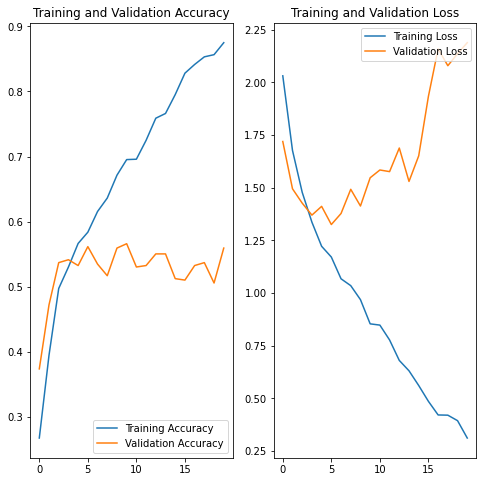

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### As you can see from the plots, training accuracy and validation accuracy are off by large margin and the model has achieved only around 55% accuracy on the validation set.

#### Let's look at what went wrong and try to increase the overall performance of the model.


### Write your findings here

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 55% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of overfitting.

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this assignment, you'll use data augmentation and add Dropout to your model.

## Data augmentation

Overfitting generally occurs when there are a small number of training examples.Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.
Will implement data augmentation using the layers from `tf.keras.layers.experimental.preprocessing`.

In [19]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
data_augmentation = keras.Sequential([layers.experimental.preprocessing.RandomFlip("horizontal", 
                                      input_shape=(img_height,img_width,3)),
                    layers.experimental.preprocessing.RandomRotation(0.1),
                    layers.experimental.preprocessing.RandomZoom(0.1),])                             

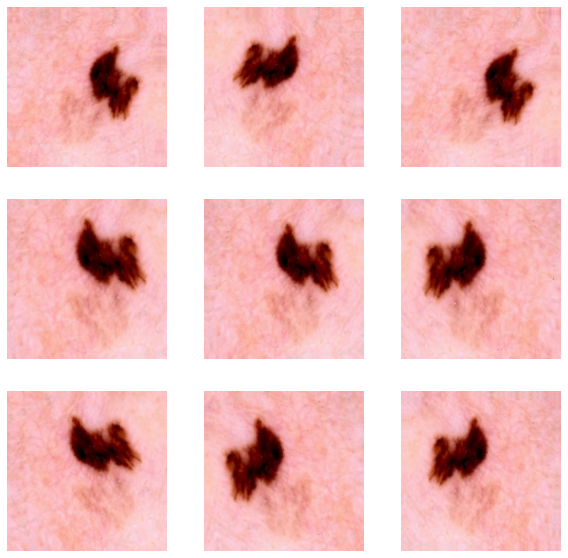

In [20]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[10].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [21]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),  
  layers.Dropout(0.17),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation = 'softmax')
])


### Compiling the model

In [22]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [23]:
# View the summary of all layers
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

### Training the model

In [24]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 3s 43ms/step - loss: 2.1514 - accuracy: 0.2109 - val_loss: 1.9024 - val_accuracy: 0.2573
Epoch 2/20
56/56 [==============================] - 2s 40ms/step - loss: 1.7855 - accuracy: 0.3354 - val_loss: 1.6596 - val_accuracy: 0.3557
Epoch 3/20
56/56 [==============================] - 2s 39ms/step - loss: 1.6457 - accuracy: 0.4012 - val_loss: 1.7323 - val_accuracy: 0.3691
Epoch 4/20
56/56 [==============================] - 2s 40ms/step - loss: 1.5156 - accuracy: 0.4654 - val_loss: 1.4229 - val_accuracy: 0.5168
Epoch 5/20
56/56 [==============================] - 2s 40ms/step - loss: 1.4467 - accuracy: 0.4704 - val_loss: 1.4423 - val_accuracy: 0.5056
Epoch 6/20
56/56 [==============================] - 2s 40ms/step - loss: 1.3716 - accuracy: 0.5033 - val_loss: 1.4508 - val_accuracy: 0.5168
Epoch 7/20
56/56 [==============================] - 2s 40ms/step - loss: 1.3378 - accuracy: 0.5234 - val_loss: 1.3260 - val_accuracy: 0.5436
Epoch 8/20
56

### Visualizing the results

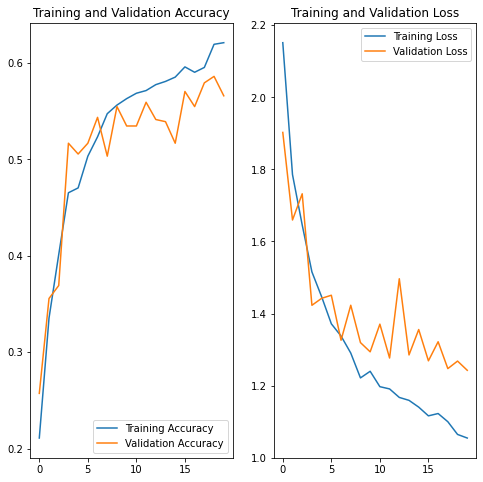

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

There is significant improvement in the model fit after data augmentation as compared without data augmentation. The validation accuracy is improved vis-a-vis training accuracy after data augmentation. Previously the training and validation accuracy error was quite significant which has been imporoved as well after data augmentation.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [26]:
## Your code goes here.
image_count = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count)

2239


In [27]:
class_dic={k: 0 for v, k in enumerate(class_names)}
base_dir="C:\\Users\\abhis\\OneDrive\\Documents\\Upgrad\\Neural Network\\CNN\\CNN Assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\"
for i in class_names:
    path, dirs, files = next(os.walk(base_dir+i))
    file_count = len(files)
    class_dic[i]=file_count
    #print(i,file_count)
#print(class_dic)
ImgCountDf=pd.DataFrame(class_dic.items(),columns=['ClassType','Count'])
ImgCountDf.head(9).sort_values(by='Count')

,ClassType,Count
6,seborrheic keratosis,77
2,dermatofibroma,95
0,actinic keratosis,114
8,vascular lesion,139
7,squamous cell carcinoma,181
4,nevus,357
1,basal cell carcinoma,376
3,melanoma,438
5,pigmented benign keratosis,462


#### **Todo:** Write your findings here: 
The dataset observed above there is huge class imbalance where you can see certain classes has higher number of observations.
Certain classes has very less number of observations so the dataset is skewed in classes regard.
#### - Which class has the least number of samples? 
##### - Ans. seborrheic keratosis
#### - Which classes dominate the data in terms proportionate number of samples? 
#### - Ans.1. nevus 2. basal cell carcinoma 3. melanoma 4.pigmented benign keratosis


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [28]:
 pip install Augmentor


Note: you may need to restart the kernel to use updated packages.


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [29]:
path_to_training_dataset ="C:\\Users\\abhis\\Documents\\Upgrad\\Neural Network\\CNN\\CNN Assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to C:\Users\abhis\Documents\Upgrad\Neural Network\CNN\CNN Assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\actinic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1CC3ABE8A88>: 100%|██████████| 500/500 [00:03<00:00, 139.75 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to C:\Users\abhis\Documents\Upgrad\Neural Network\CNN\CNN Assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\basal cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1CC3B207B88>: 100%|██████████| 500/500 [00:03<00:00, 141.01 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to C:\Users\abhis\Documents\Upgrad\Neural Network\CNN\CNN Assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\dermatofibroma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1CB94177948>: 100%|██████████| 500/500 [00:03<00:00, 138.44 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to C:\Users\abhis\Documents\Upgrad\Neural Network\CNN\CNN Assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1CC3B1E7BC8>: 100%|██████████| 500/500 [00:17<00:00, 27.93 Samples/s] 
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to C:\Users\abhis\Documents\Upgrad\Neural Network\CNN\CNN Assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\nevus\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=767x576 at 0x1CB9415C2C8>: 100%|██████████| 500/500 [00:15<00:00, 31.74 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 462 image(s) found.
Output directory set to C:\Users\abhis\Documents\Upgrad\Neural Network\CNN\CNN Assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1CB8C3010C8>: 100%|██████████| 500/500 [00:03<00:00, 164.19 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to C:\Users\abhis\Documents\Upgrad\Neural Network\CNN\CNN Assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1CB9420D648>: 100%|██████████| 500/500 [00:07<00:00, 71.29 Samples/s] 
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 181 image(s) found.
Output directory set to C:\Users\abhis\Documents\Upgrad\Neural Network\CNN\CNN Assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1CB940B0408>: 100%|██████████| 500/500 [00:03<00:00, 148.42 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to C:\Users\abhis\Documents\Upgrad\Neural Network\CNN\CNN Assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1CB8C80F048>: 100%|██████████| 500/500 [00:03<00:00, 158.03 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [30]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [31]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['C:\\Users\\abhis\\Documents\\Upgrad\\Neural Network\\CNN\\CNN Assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_033d8dff-3f9c-49d0-95b2-b68b83d4080f.jpg',
 'C:\\Users\\abhis\\Documents\\Upgrad\\Neural Network\\CNN\\CNN Assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_148176fc-9188-4cbf-82fb-a05720f3509c.jpg',
 'C:\\Users\\abhis\\Documents\\Upgrad\\Neural Network\\CNN\\CNN Assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_3c65f71a-babb-4cd6-8950-078b361f10ce.jpg',
 'C:\\Users\\abhis\\Documents\\Upgrad\\Neural Network\\CNN\\CNN Assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_60b

In [32]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new


['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [33]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))
dataframe_dict_new

{'C:\\Users\\abhis\\Documents\\Upgrad\\Neural Network\\CNN\\CNN Assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_033d8dff-3f9c-49d0-95b2-b68b83d4080f.jpg': 'actinic keratosis',
 'C:\\Users\\abhis\\Documents\\Upgrad\\Neural Network\\CNN\\CNN Assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_148176fc-9188-4cbf-82fb-a05720f3509c.jpg': 'actinic keratosis',
 'C:\\Users\\abhis\\Documents\\Upgrad\\Neural Network\\CNN\\CNN Assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_3c65f71a-babb-4cd6-8950-078b361f10ce.jpg': 'actinic keratosis',
 'C:\\Users\\abhis\\Documents\\Upgrad\\Neural Network\\CNN\\CNN Assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic ker

In [34]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)
new_df

,Path,Label
0,C:\Users\abhis\Documents\Upgrad\Neural Network...,actinic keratosis
1,C:\Users\abhis\Documents\Upgrad\Neural Network...,actinic keratosis
2,C:\Users\abhis\Documents\Upgrad\Neural Network...,actinic keratosis
3,C:\Users\abhis\Documents\Upgrad\Neural Network...,actinic keratosis
4,C:\Users\abhis\Documents\Upgrad\Neural Network...,actinic keratosis
...,...,...
4495,C:\Users\abhis\Documents\Upgrad\Neural Network...,vascular lesion
4496,C:\Users\abhis\Documents\Upgrad\Neural Network...,vascular lesion
4497,C:\Users\abhis\Documents\Upgrad\Neural Network...,vascular lesion
4498,C:\Users\abhis\Documents\Upgrad\Neural Network...,vascular lesion


In [35]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [36]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [37]:
data_dir_train="C:\\Users\\abhis\\Documents\\Upgrad\\Neural Network\\CNN\\CNN Assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [38]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [81]:
## your code goes here
num_classes = 9

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),  
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),  
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes, activation = 'softmax')
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [83]:
## your code goes here
model.compile(optimizer='SGD',
              loss= tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [84]:
# View the summary of all layers
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_11 (Rescaling)     (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
batch_normalization_6 (Batch (None, 180, 180, 16)      64        
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
batch_normalization_7 (Batch (None, 90, 90, 32)      

#### **Todo:**  Train your model

In [85]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 21s 119ms/step - loss: 1.7613 - accuracy: 0.4082 - val_loss: 8.5585 - val_accuracy: 0.1084
Epoch 2/50
169/169 [==============================] - 20s 119ms/step - loss: 1.2094 - accuracy: 0.5376 - val_loss: 4.8243 - val_accuracy: 0.1759
Epoch 3/50
169/169 [==============================] - 21s 120ms/step - loss: 1.0770 - accuracy: 0.5849 - val_loss: 3.1527 - val_accuracy: 0.3148
Epoch 4/50
169/169 [==============================] - 21s 119ms/step - loss: 0.9555 - accuracy: 0.6382 - val_loss: 1.9975 - val_accuracy: 0.3979
Epoch 5/50
169/169 [==============================] - 21s 119ms/step - loss: 0.8717 - accuracy: 0.6708 - val_loss: 1.4551 - val_accuracy: 0.5182
Epoch 6/50
169/169 [==============================] - 21s 124ms/step - loss: 0.8128 - accuracy: 0.6942 - val_loss: 1.5699 - val_accuracy: 0.4796
Epoch 7/50
169/169 [==============================] - 21s 121ms/step - loss: 0.7672 - accuracy: 0.7164 - val_loss: 1.6325 - val_ac

#### **Todo:**  Visualize the model results

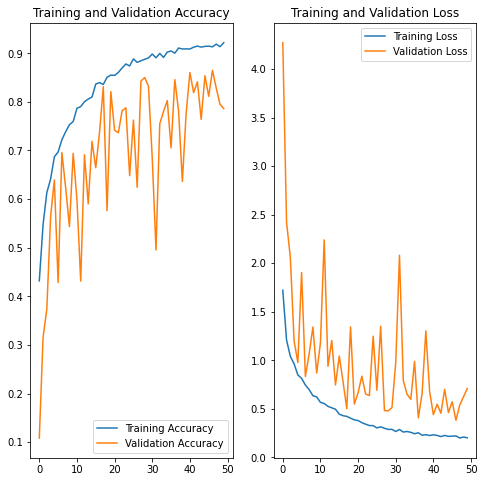

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?
As we can see from above graph, batch normalization is able to reduce overfitting slightly and giving better results on using the batch normalisation with 50 epochs and SGD as a optimiser as well as Sparse categorical cross entropy as a loss.


#### **Todo:** Create your model (make sure to include normalization)

In [66]:
## your code goes here
num_classes = 9

model1 = Sequential([data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size =(2,2)),                
  layers.Conv2D(32, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size =(2,2)),         
                    
  layers.Conv2D(64, (3,3), padding='same', activation='relu'),                   
  layers.MaxPooling2D(pool_size =(2,2)),                   
  
  layers.Flatten(),  
  layers.Dense(128, activation='relu'),
                     
  layers.Dense(num_classes,activation = 'softmax')
])

In [67]:
## your code goes here
model1.compile(optimizer='Adam',
              loss= tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [68]:
# View the summary of all layers
model1.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_8 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 45, 45, 64)       

### Running 20 epochs as per evaluation rubric

In [69]:
epochs = 20
## Your code goes here, use 50 epochs.
history = model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 21s 115ms/step - loss: 1.9009 - accuracy: 0.2737 - val_loss: 1.5601 - val_accuracy: 0.4105
Epoch 2/20
169/169 [==============================] - 24s 139ms/step - loss: 1.5072 - accuracy: 0.4271 - val_loss: 1.3595 - val_accuracy: 0.4618
Epoch 3/20
169/169 [==============================] - 20s 117ms/step - loss: 1.3442 - accuracy: 0.4881 - val_loss: 1.2996 - val_accuracy: 0.5041
Epoch 4/20
169/169 [==============================] - 19s 110ms/step - loss: 1.2684 - accuracy: 0.5124 - val_loss: 1.1885 - val_accuracy: 0.5509
Epoch 5/20
169/169 [==============================] - 22s 125ms/step - loss: 1.2162 - accuracy: 0.5395 - val_loss: 1.2050 - val_accuracy: 0.5405
Epoch 6/20
169/169 [==============================] - 23s 135ms/step - loss: 1.1631 - accuracy: 0.5670 - val_loss: 1.1700 - val_accuracy: 0.5501
Epoch 7/20
169/169 [==============================] - 23s 135ms/step - loss: 1.1019 - accuracy: 0.5896 - val_loss: 1.0836 - val_ac

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?




As you can see class rebalance really helped for the model accuracy and difference between training accuracy and validation accuracy is very less so it reduced overfitting of the model.Previously the training and validation accuracy error was quite significant which has been imporoved as well after data rebalance as well.

In [70]:
## your code goes here
num_classes = 9

model2 = Sequential([data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size =(2,2)),
# layers.Dropout(0.15),                  
                  
  layers.Conv2D(32, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size =(2,2)),
# layers.Dropout(0.2),                  
                    
                    
  layers.Conv2D(64, (3,3), padding='same', activation='relu'),                   
  layers.MaxPooling2D(pool_size =(2,2)),
  layers.Dropout(0.3),                  
  
  layers.Flatten(),  
  layers.Dense(128, activation='relu'),   
                     
  layers.Dense(num_classes,activation = 'softmax')
])

In [72]:
## your code goes here
model2.compile(optimizer='Adam',
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [73]:
# View the summary of all layers
model2.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_9 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 45, 45, 64)      

In [75]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 18s 99ms/step - loss: 1.8280 - accuracy: 0.2932 - val_loss: 1.5475 - val_accuracy: 0.3979
Epoch 2/50
169/169 [==============================] - 17s 100ms/step - loss: 1.5198 - accuracy: 0.4338 - val_loss: 1.5266 - val_accuracy: 0.4350
Epoch 3/50
169/169 [==============================] - 18s 102ms/step - loss: 1.3751 - accuracy: 0.4794 - val_loss: 1.2891 - val_accuracy: 0.5345
Epoch 4/50
169/169 [==============================] - 18s 103ms/step - loss: 1.2935 - accuracy: 0.5141 - val_loss: 1.2570 - val_accuracy: 0.5271
Epoch 5/50
169/169 [==============================] - 18s 103ms/step - loss: 1.2308 - accuracy: 0.5362 - val_loss: 1.2669 - val_accuracy: 0.5293
Epoch 6/50
169/169 [==============================] - 18s 103ms/step - loss: 1.1793 - accuracy: 0.5536 - val_loss: 1.4517 - val_accuracy: 0.4699
Epoch 7/50
169/169 [==============================] - 18s 105ms/step - loss: 1.1294 - accuracy: 0.5727 - val_loss: 1.2088 - val_acc

### Fitted model 3 boosed training accuracy training around 87% while validation accuracy 81%.
### Further corroborated by the fact that both training & validation loss showed-up a declining trend with incremental epochs .
### Model seems to have improved the performance on the back of:
###  i) Rebalance minority classes by augmenting data (500 samples) to overcome any classes with sparse samples.
### ii) Increasing the dropout from 20% to 30% helped in keeping a check on model complexity hence prevented overfitting.
